#### Import libraries & set-up holidays

In [1]:
import pandas as pd
import numpy as np
#import tiingo
import requests
from tqdm import tqdm
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly



## Create holiday calendar
cal = calendar()

holidays = cal.holidays(start='2000-01-01',
                        end='2030-12-30')

holiday_df = pd.DataFrame(data=holidays,
                          columns = ['date']).assign(holiday='USFederalHoliday')

holiday_df.rename(columns={'date':'ds'},inplace=True)
#holiday_df.to_csv('us_holidays_until_2030.csv')

In [2]:
### First we will get the 15min time intervals and calculate the 15min Moving averages (10 perido, 20 period, 50 period)
### From the same data we will also calculate the 1d Moving averages (10 period, 20 period, 50 period) and
### Append the indicators to the dataframe 
### Each iteration will run for a single ticker


### The data extracts work in 0GMT => Exchange opens at 14:30 and closes at 21:00
### Convert this to Sofia/New-York time if needed


#### Connect to tiingo

In [14]:
ticker = 'SPY'
start_date = '2020-08-01'
### The data extracts work in 0GMT => Exchange opens at 14:30 and closes at 21:00
### Convert this to Sofia/New-York time if needed

#### Connect to tiingo
# 15min to # 1h 
headers = {
    'Content-Type': 'application/json'
}
requestResponse = requests.get("https://api.tiingo.com/tiingo/daily/"+str(ticker)+"/prices?startDate="+str(start_date)+"&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
#print(requestResponse.json())


In [15]:
df_stock = pd.DataFrame(requestResponse.json()) 
#df_stock
## This gets financial data
#requestResponse = requests.get("https://api.tiingo.com/tiingo/fundamentals/msft/statements?token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
#print(requestResponse.json)
requestResponse
df_stock = pd.DataFrame(requestResponse.json()) 
#df_stock
df_stock.date = pd.to_datetime(df_stock.date)
#df_stock.date.dt.date
## Remove the US public holidays
df_stock = df_stock[~df_stock.date.dt.date.isin(holiday_df.ds)]
#df_stock.dtypes
df_stock.rename(columns={"date": "ds", "close": "y"},inplace=True)
df_stock.ds = df_stock.ds.dt.tz_convert(None)
df_stock.ds.dt.day_name().value_counts()

c:\Users\IvanIvanov\Anaconda3\lib\site-packages\pandas\core\algorithms.py:524: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



Tuesday      122
Wednesday    122
Thursday     119
Friday       117
Monday       111
Name: ds, dtype: int64

#### Prophet

In [16]:
# Python
m = Prophet(holidays=holiday_df, growth = 'linear')
# m = Prophet(holidays=holiday_df, growth = 'linear')
m.fit(df_stock[['ds','y']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [17]:
# Python
# Frequency 5min for minute ones D for daily
future = m.make_future_dataframe(periods=100, freq='D')
future.tail()

,ds
686,2023-03-11
687,2023-03-12
688,2023-03-13
689,2023-03-14
690,2023-03-15


#### Prediction results

In [18]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100)

,ds,yhat,yhat_lower,yhat_upper
591,2022-12-06,390.077377,380.103839,400.676482
592,2022-12-07,389.621459,379.744728,398.837033
593,2022-12-08,388.987686,378.331799,399.153100
594,2022-12-09,388.430220,378.122528,399.293154
595,2022-12-10,386.934523,376.841404,396.418184
...,...,...,...,...
686,2023-03-11,359.686557,347.389076,372.996772
687,2023-03-12,360.353655,347.909210,373.344578
688,2023-03-13,361.621494,349.339072,374.425389
689,2023-03-14,362.497551,349.030933,375.314897


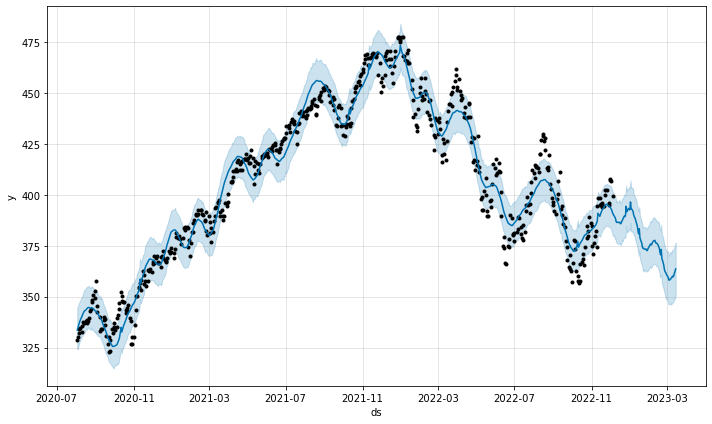

In [19]:
# Python
fig1 = m.plot(forecast)

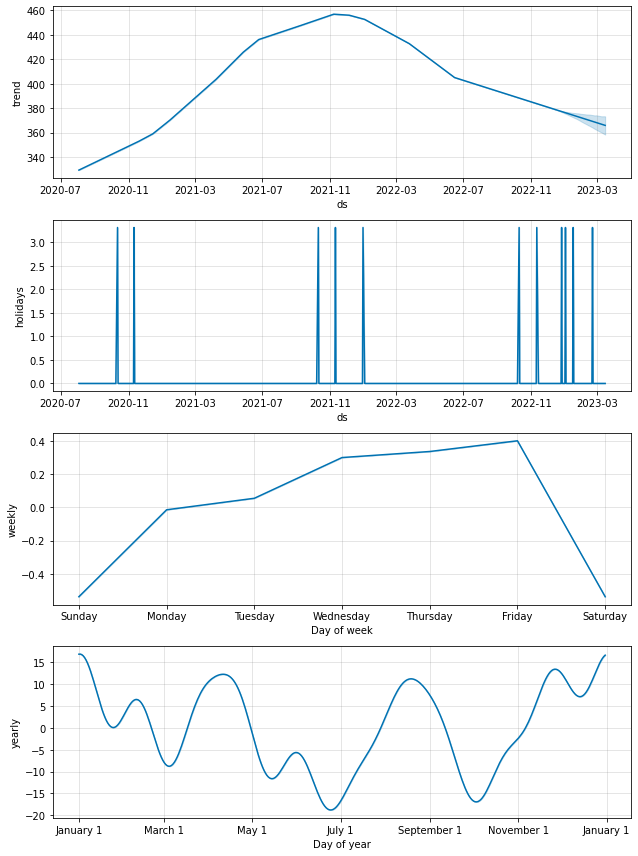

In [20]:
# Python
fig2 = m.plot_components(forecast)

In [21]:
# Python
plot_plotly(m, forecast)

In [22]:
# Python
plot_components_plotly(m, forecast)

#### Appendix

In [23]:
# import xgboost as xgb 
# clf_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
#                             tree_method = 'gpu_hist',
#                             gamma = 0.5,
#                            max_depth = 25,
#                             seed=42,
#                             n_estimators=30)

In [13]:
# clf_xgb.fit(X_train,
#             y_train,
#            verbose=True,
#             early_stopping_rounds=20,
#             eval_metric='rmse',   #aucpr,auc, map
#             eval_set=[(X_test,y_test)])